# **Bioinformatics Project - Computational Drug Discovery [Part 2] Exploratory Data Analysis**

**MOUNSIF EL ATOUCH**


In this Jupyter notebook, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 2**, we will be performing Descriptor Calculation and Exploratory Data Analysis.

---

## **Installing libraries**

In [1]:
! pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 61.8 MB/s eta 0:00:00


## **Importing libraries**

In [12]:
import pandas as pd #data processing, CSV file I/O (e.g. pd.read_csv)
import warnings #ignore warnings
warnings.filterwarnings('ignore')
import numpy as np #linear algebra
from rdkit import Chem #working with molecular structures
from rdkit.Chem import Descriptors, Lipinski
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

## **Load bioactivity data**

In [55]:
df = pd.read_csv('bioactivity_data_curated.csv')

In [56]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [57]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [58]:
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1)

## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

### **Calculate descriptors**

In [59]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [60]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)

### **Combine DataFrames**
Now, let's combine the 2 DataFrame

In [61]:
df_combined = pd.concat([df, df_lipinski], axis=1)

In [62]:
df_combined

,molecule_chembl_id,canonical_smiles,target,pIC50,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL243822,Oc1ccc(CCc2ccc(O)c(O)c2O)cc1,inactive,4.522879,246.262,2.29420,4.0,4.0
1,CHEMBL734,CC(=O)NO,inactive,4.769551,75.067,-0.48830,2.0,2.0
2,CHEMBL242739,O=c1c(-c2ccc(O)cc2)coc2c(O)c(O)ccc12,inactive,3.853872,270.240,2.57680,3.0,5.0
3,CHEMBL503157,N=C(Cc1ccc(O)cc1)c1ccc(O)c(O)c1,inactive,4.769551,243.262,2.41397,4.0,4.0
4,CHEMBL412199,NC(Cc1ccc(O)cc1)c1ccc(O)c(O)c1O,inactive,4.327902,261.277,1.75150,5.0,5.0
...,...,...,...,...,...,...,...,...
249,CHEMBL4539240,CCC(CO)NC(=O)c1ccccc1[Se][Se]c1ccccc1C(=O)NC(C...,inactive,3.966576,542.396,-0.03780,4.0,4.0
250,CHEMBL4461450,O=C(O)CCCNC(=O)c1ccccc1[Se][Se]c1ccccc1C(=O)NC...,inactive,4.450997,570.362,0.15000,4.0,4.0
251,CHEMBL4471428,COC(=O)CNC(=O)c1ccccc1[Se][Se]c1ccccc1C(=O)NCC...,inactive,4.070581,542.308,-1.23360,2.0,6.0
252,CHEMBL4575318,COC(=O)CCCNC(=O)c1ccccc1[Se][Se]c1ccccc1C(=O)N...,inactive,4.696804,598.416,0.32680,2.0,6.0


In [63]:
df_combined.to_csv('bioactivity_combined_data.csv', index=False)

---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

In [64]:
data = df_combined.copy()

### **Target distribution**

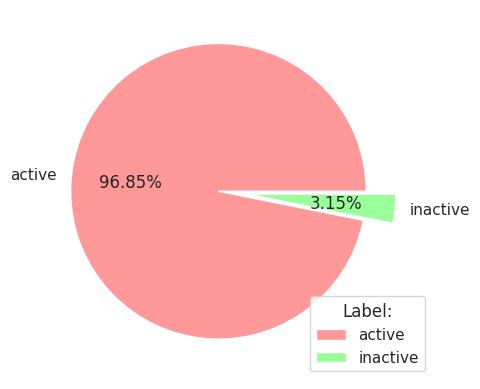

<Figure size 640x480 with 0 Axes>

In [65]:
labels = 'active', 'inactive'
colors = ['#ff9999', '#99ff99']
myexplode = [0.2, 0]
plt.pie(data['target'].value_counts(), labels=labels, colors=colors, autopct='%1.2f%%', explode=myexplode)
plt.legend(title="Label:")
plt.show() 

plt.savefig('plot_target_distribution.pdf')

### **Frequency plot of the 2 bioactivity classes**

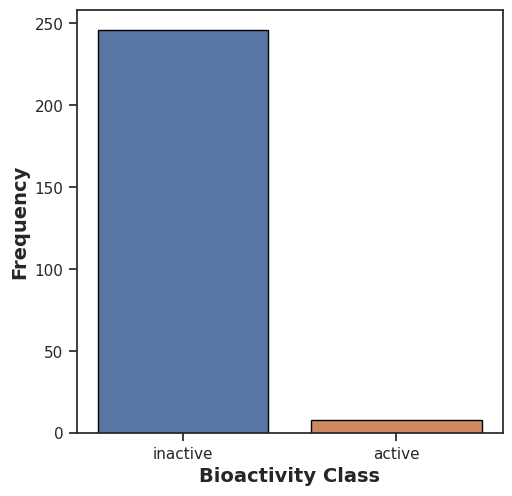

In [79]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='target', data=data, edgecolor='black')

plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

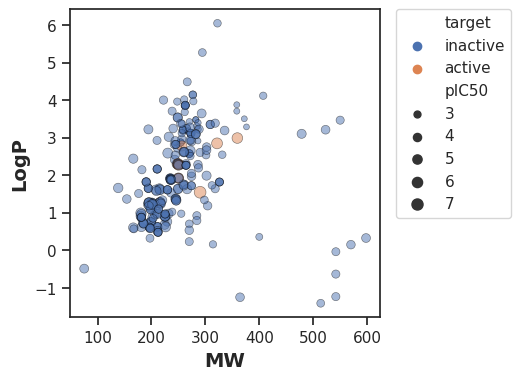

In [86]:
plt.figure(figsize=(4, 4))

sns.scatterplot(x='MW', y='LogP', data=data, hue='target', size='pIC50', edgecolor='black', alpha=0.5)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

Most of the compounds have a molecular weight of between 200 and 500 Da and logP values between 1 and 6. This is reasonable as drugs with MW>500 and logP>5 tend to lead to poor absorption. Good absorption is needed for orally administered drugs. 

### **Box plots**

#### **pIC50 value**

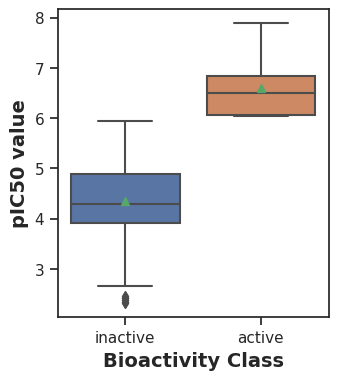

In [107]:
plt.figure(figsize=(3.5, 4))

sns.boxplot(x='target', y='pIC50', data=data, showmeans=True)

plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_pIC50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [88]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'target']
  df = data[selection]
  active = df[df['target'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'target']
  df = data[selection]
  inactive = df[df['target'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

**Statistical analysis | Mann-Whitney U Test**

In [89]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,1968.0,0.000002,0.05,Different distribution (reject H0)


As expected, the pIC50 values for active compounds are lower than for inactive compounds.

#### **MW**

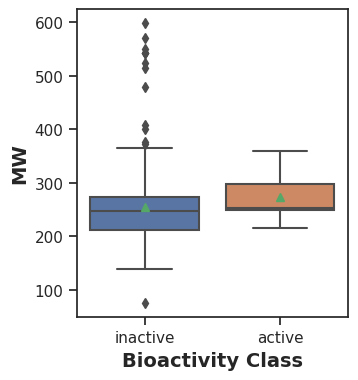

In [106]:
plt.figure(figsize=(3.5, 4))

sns.boxplot(x='target', y='MW', data=data, showmeans=True)

plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [92]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1277.5,0.151912,0.05,Same distribution (fail to reject H0)


#### **LogP**

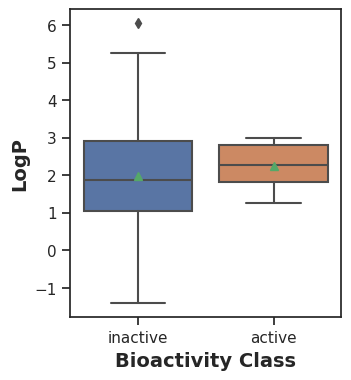

In [105]:
plt.figure(figsize=(3.5, 4))

sns.boxplot(x='target', y='LogP', data=data, showmeans=True)

plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [94]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1150.0,0.418334,0.05,Same distribution (fail to reject H0)


#### **NumHDonors**

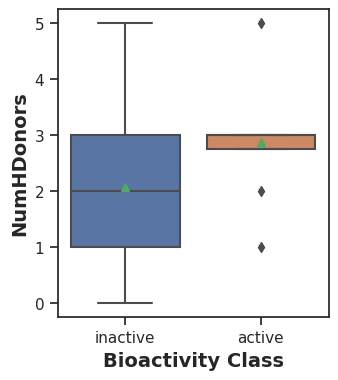

In [108]:
plt.figure(figsize=(3.5, 4))

sns.boxplot(x='target', y='NumHDonors', data=data, showmeans=True)

plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [96]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1369.0,0.049762,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

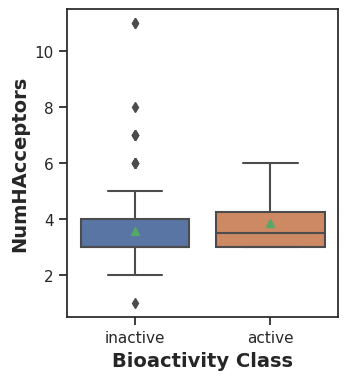

In [109]:
plt.figure(figsize=(3.5, 4))

sns.boxplot(x='target', y='NumHAcceptors', data=data, showmeans=True)

plt.xlabel('Bioactivity Class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [110]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1147.0,0.38402,0.05,Same distribution (fail to reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 <= 1000 nM = Actives while IC50 > 1000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 6 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

Based on the boundaries of the boxes, there are no differences between the two bioactivity classes for MW, LogP and NumHAcceptors. However, there is a weak trend of differences between the bioactivity groups for NumHDonors, suggesting the active bioactivity classes higher NumHDonors values.

---

